# 1. Identify an Unsupervised Learning Problem

### Problem Definition
The goal is to detect anomalous credit card transactions without relying on labels. The anomalies may indicate potential fraud and can be identified based on:
1. Spatial Outliers: Unusual geographic locations.
2. Temporal Outliers: High-frequency transactions.
3. Monetary Outliers: Transactions exceeding normal spending habits or credit limits.

### Unsupervised Learning Approach
We will use the following methods:
1. Clustering:
   - Group transactions based on patterns and analyze anomalies within clusters.
2. Anomaly Detection:
   - Employ algorithms like Isolation Forests and DBSCAN to identify transactions deviating from normal patterns.

### Unique Contribution
This project will:
1. Incorporate spatial-temporal analysis for anomaly detection.
2. Use custom features to capture spending behavior and geographic patterns.
3. Compare multiple algorithms to evaluate their effectiveness in detecting anomalies.
4. Provide visualizations for insights into transaction anomalies.

### Justification
This approach goes beyond replicating existing work by combining spatial, temporal, and monetary features with novel unsupervised techniques.


# 2. Exploratory Data Analysis (EDA)

### Objective
Perform EDA to inspect, visualize, and clean the data. This will include understanding data distributions, relationships between features, and preparing the data for unsupervised learning.


### 1. Inspecting the Data


In [1]:
# Load required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
cc_info = pd.read_csv('./dataset/cc_info.csv')
transactions = pd.read_csv('./dataset/transactions.csv')

# Display dataset info
print("Credit Card Info Dataset:")
print(cc_info.info())
print(cc_info.head())

print("\nTransactions Dataset:")
print(transactions.info())
print(transactions.head())


Credit Card Info Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   credit_card        984 non-null    int64 
 1   city               984 non-null    object
 2   state              984 non-null    object
 3   zipcode            984 non-null    int64 
 4   credit_card_limit  984 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 38.6+ KB
None
        credit_card      city state  zipcode  credit_card_limit
0  1280981422329509    Dallas    PA    18612               6000
1  9737219864179988   Houston    PA    15342              16000
2  4749889059323202    Auburn    MA     1501              14000
3  9591503562024072   Orlando    WV    26412              18000
4  2095640259001271  New York    NY    10001              20000

Transactions Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587


## Data Distributions
Visualize numeric features in `cc_info.csv`


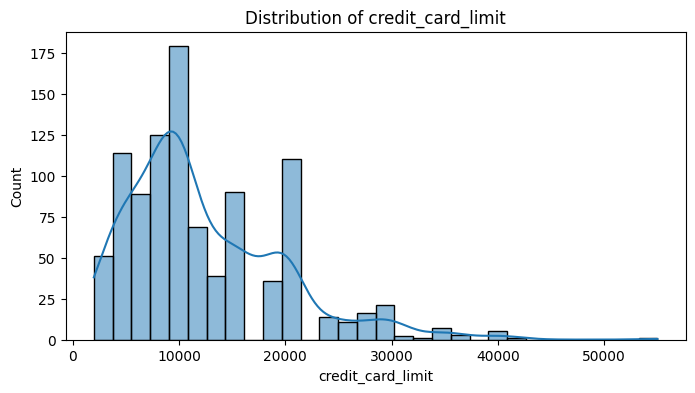

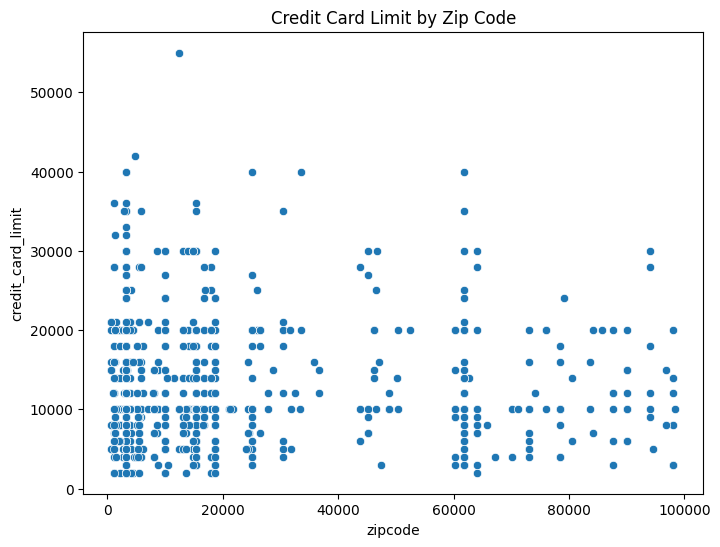

In [2]:
# Plot histograms for numeric features
numeric_features = ['credit_card_limit']
for feature in numeric_features:
    plt.figure(figsize=(8, 4))
    sns.histplot(cc_info[feature], bins=30, kde=True)
    plt.title(f'Distribution of {feature}')
    plt.show()

# Scatter plot for geographic coordinates
plt.figure(figsize=(8, 6))
sns.scatterplot(data=cc_info, x='zipcode', y='credit_card_limit')
plt.title('Credit Card Limit by Zip Code')
plt.show()


## Visualize numeric features in `transactions.csv`


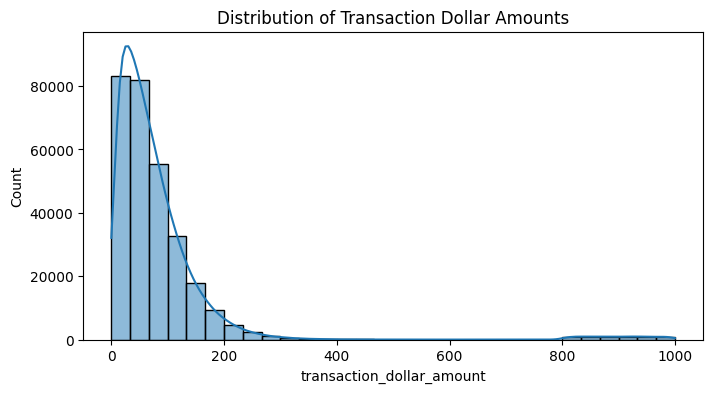

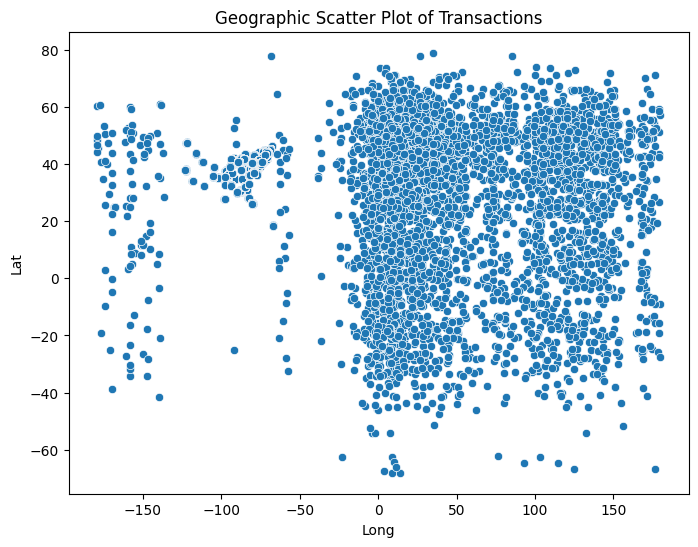

In [3]:
# Plot distribution of transaction amounts
plt.figure(figsize=(8, 4))
sns.histplot(transactions['transaction_dollar_amount'], bins=30, kde=True)
plt.title('Distribution of Transaction Dollar Amounts')
plt.show()

# Scatter plot for Lat and Long
plt.figure(figsize=(8, 6))
sns.scatterplot(data=transactions, x='Long', y='Lat')
plt.title('Geographic Scatter Plot of Transactions')
plt.show()


## Relationships and Correlations

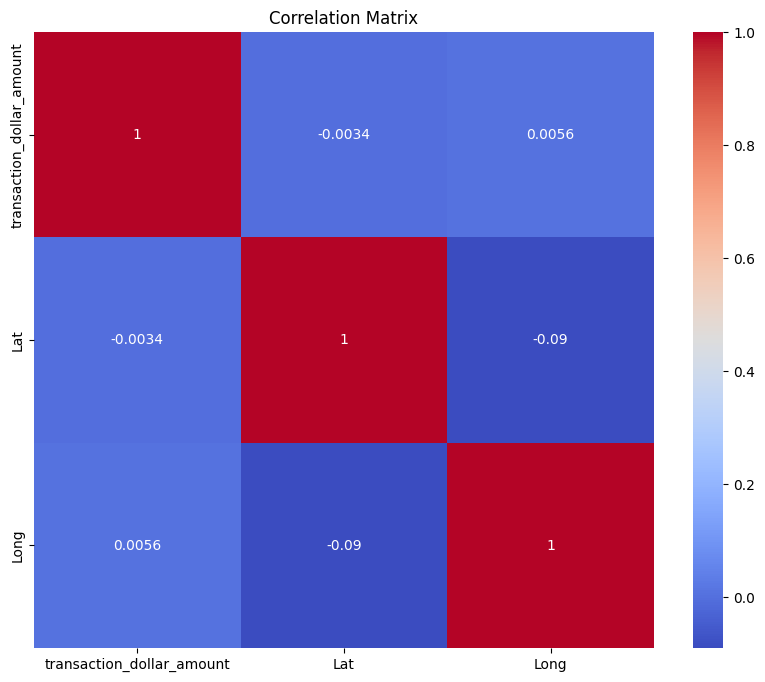

In [4]:
# Correlation matrix for numeric features
plt.figure(figsize=(10, 8))
correlation_matrix = transactions[['transaction_dollar_amount', 'Lat', 'Long']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


## Identifying Outliers and Missing Data

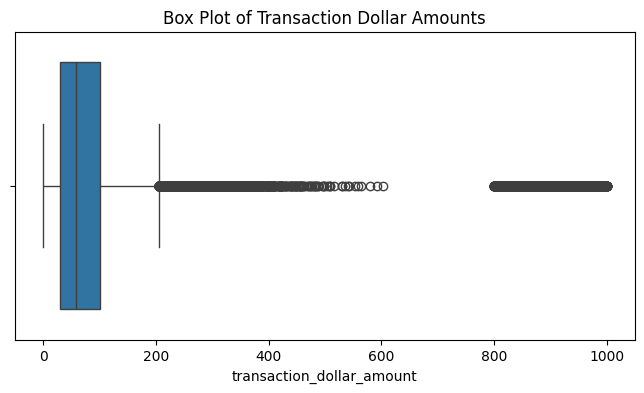

Missing values in cc_info.csv:
credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

Missing values in transactions.csv:
credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64


In [5]:
# Box plot to detect outliers in transaction amounts
plt.figure(figsize=(8, 4))
sns.boxplot(data=transactions, x='transaction_dollar_amount')
plt.title('Box Plot of Transaction Dollar Amounts')
plt.show()

# Check for missing values
print("Missing values in cc_info.csv:")
print(cc_info.isnull().sum())

print("\nMissing values in transactions.csv:")
print(transactions.isnull().sum())


## Feature Engineering
#### Derived Features
- **Transaction Frequency**: Calculate the number of transactions per day for each credit card.
- **Geographic Distance**: Calculate the distance between consecutive transactions using `Lat` and `Long`.
- **Spending Deviation**: Measure the difference between each transaction amount and the credit card limit.


In [6]:
# Example: Transaction Frequency
transactions['date'] = pd.to_datetime(transactions['date'])
transactions['day'] = transactions['date'].dt.date
transaction_freq = transactions.groupby(['credit_card', 'day']).size().reset_index(name='transaction_count')

# Example: Spending Deviation
cc_info = cc_info.rename(columns={'credit_card': 'credit_card_id'})
merged = transactions.merge(cc_info, left_on='credit_card', right_on='credit_card_id', how='left')
merged['spending_deviation'] = merged['transaction_dollar_amount'] - merged['credit_card_limit']


## Data Transformation
- Normalization: Apply Min-Max scaling or Standardization to features with large ranges.
- Log Transformation: Apply log transformation to positively skewed data (e.g., `transaction_dollar_amount`).


In [7]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler = MinMaxScaler()
transactions['scaled_transaction_amount'] = scaler.fit_transform(transactions[['transaction_dollar_amount']])


# 3. Perform Analysis Using Unsupervised Learning Models

### 1. Data Preparation
Prepare the data by selecting relevant features, handling scaling, and creating derived features for clustering and anomaly detection.


In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Select relevant features for modeling
model_features = transactions[['transaction_dollar_amount', 'Long', 'Lat']].copy()

# Standardize features for clustering and anomaly detection
scaler = StandardScaler()
scaled_features = scaler.fit_transform(model_features)

# Prepare features for anomaly detection
merged['spending_deviation'] = merged['transaction_dollar_amount'] - merged['credit_card_limit']
anomaly_features = merged[['transaction_dollar_amount', 'spending_deviation', 'Long', 'Lat']]
scaled_anomaly_features = scaler.fit_transform(anomaly_features)


### 2. Models: K-Means Clustering & Isolation Forest


Scaling the features...
Running Mini-Batch K-Means...
Silhouette Score for Mini-Batch K-Means: 0.2704247507444454


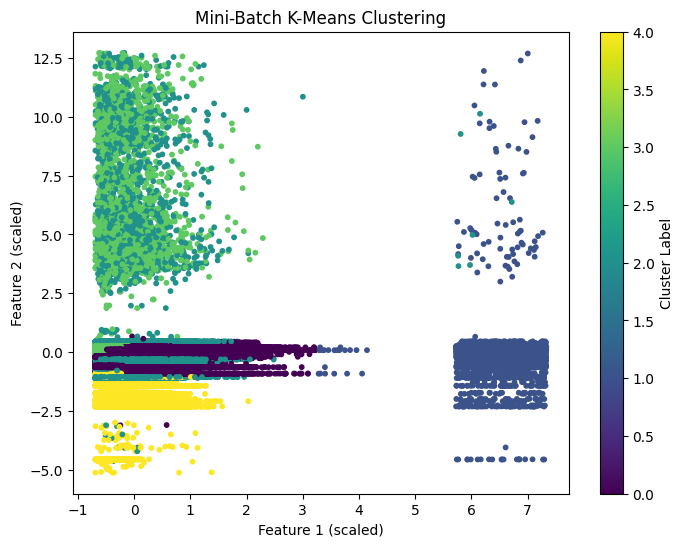

Running Isolation Forest for anomaly detection...


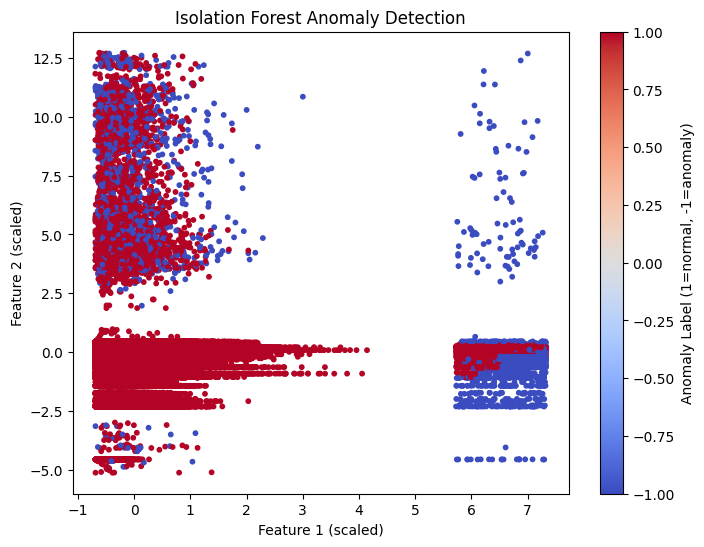


Mini-Batch K-Means Cluster Counts:
Cluster 0: 165212 transactions
Cluster 1: 5468 transactions
Cluster 2: 16296 transactions
Cluster 3: 91225 transactions
Cluster 4: 16387 transactions

Isolation Forest Anomaly Counts:
Normal Transactions: 291642
Anomalous Transactions: 2946


In [9]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.ensemble import IsolationForest
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the data
print("Scaling the features...")
scaler = StandardScaler()
scaled_features = scaler.fit_transform(model_features)

# Step 2: Mini-Batch K-Means
print("Running Mini-Batch K-Means...")
mb_kmeans = MiniBatchKMeans(n_clusters=5, random_state=42, batch_size=1000, init="k-means++")
mb_kmeans_labels = mb_kmeans.fit_predict(scaled_features)

# Silhouette Score for Mini-Batch K-Means
subset_indices = np.random.choice(len(scaled_features), size=5000, replace=False)
subset_features = scaled_features[subset_indices]
subset_labels = mb_kmeans_labels[subset_indices]

silhouette = silhouette_score(subset_features, subset_labels)
print(f"Silhouette Score for Mini-Batch K-Means: {silhouette}")

# Visualize Mini-Batch K-Means clusters
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=mb_kmeans_labels, cmap='viridis', s=10)
plt.title('Mini-Batch K-Means Clustering')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.colorbar(label='Cluster Label')
plt.show()

# Step 3: Isolation Forest
print("Running Isolation Forest for anomaly detection...")
isolation_forest = IsolationForest(contamination=0.01, random_state=42)
anomaly_scores = isolation_forest.fit_predict(scaled_features)

# Visualize Isolation Forest anomalies
plt.figure(figsize=(8, 6))
plt.scatter(scaled_features[:, 0], scaled_features[:, 1], c=anomaly_scores, cmap='coolwarm', s=10)
plt.title('Isolation Forest Anomaly Detection')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.colorbar(label='Anomaly Label (1=normal, -1=anomaly)')
plt.show()

# Step 4: Print Results
# Count cluster sizes from Mini-Batch K-Means
cluster_counts = np.unique(mb_kmeans_labels, return_counts=True)
print("\nMini-Batch K-Means Cluster Counts:")
for cluster, count in zip(cluster_counts[0], cluster_counts[1]):
    print(f"Cluster {cluster}: {count} transactions")

# Count anomalies from Isolation Forest
anomaly_counts = np.unique(anomaly_scores, return_counts=True)
print("\nIsolation Forest Anomaly Counts:")
print(f"Normal Transactions: {anomaly_counts[1][1]}")
print(f"Anomalous Transactions: {anomaly_counts[1][0]}")


# 6. Discussion and Conclusions

## Mini-Batch K-Means Clustering
1. **Silhouette Score**:  
   - A score of **0.270** suggests moderate clustering quality, with some overlap or noise in the data.

2. **Cluster Distribution**:  
   - **Cluster 0**: 165,212 transactions (~56%). Likely represents typical transaction patterns.  
   - **Clusters 1, 2, 3, 4**: Smaller clusters indicate unique behaviors, e.g., high spending or geographic outliers.

3. **Insights**:  
   - The dominant cluster reflects homogeneous behavior, while smaller clusters highlight distinct transaction patterns.

---

## Isolation Forest Anomaly Detection
1. **Anomaly Counts**:  
   - **Normal Transactions**: 291,642 (~99%).  
   - **Anomalous Transactions**: 2,946 (~1%), consistent with rare fraudulent or unusual activity.

2. **Insights**:  
   - Anomalies likely represent geographic or spending outliers.  
   - Effective for identifying rare, unusual transactions without relying on labels.

---

## Discussion
1. **Model Comparison**:  
   - **Mini-Batch K-Means**: Groups transactions into behavioral clusters, offering insights into spending patterns.  
   - **Isolation Forest**: Pinpoints specific anomalies, making it ideal for fraud detection.

2. **Model Limitations**:  
   - **Mini-Batch K-Means**: Struggles with noise and overlapping patterns, indicated by a low silhouette score.  
   - **Isolation Forest**: Requires careful parameter tuning for optimal results.

3. **Complementary Insights**:  
   - K-Means identifies broader transaction patterns.  
   - Isolation Forest highlights rare anomalies that may indicate fraud.

---

## Conclusions
1. **Key Findings**:  
   - The majority of transactions are "normal" (~99%).  
   - Smaller clusters and anomalies may represent high-value or geographically distinct transactions.

2. **Next Steps**:  
   - Investigate smaller clusters (e.g., Cluster 1 and 4) for unique spending behaviors.  
   - Analyze anomalies for fraud patterns or unusual activities.

3. **Recommendations**:  
   - Use clustering insights to segment users for targeted monitoring.  
   - Leverage anomaly detection for real-time fraud prevention.  
   - Enhance features (e.g., geographic distance, temporal patterns) for improved model performance.

